## Object Detection using Pre-Trained Tensorflow model

## Credits
- This code is modified from the TensorFlow object detection tutorial available at:
https://github.com/tensorflow/models/blob/master/research/object_detection/object_detection_tutorial.ipynb

# Imports

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
import json

from utils import visualization_utils as vis_util

## Env setup

In [2]:
# This is needed to display the images.
%matplotlib inline

# Model preparation 

In [3]:
MODEL_NAME = 'ssd_mobilenet_v2_coco_2018_03_29'

MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

## Download Model

In [4]:
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())

## Load a (frozen) Tensorflow model into memory.

In [5]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

# Loading labels

In [6]:
with open('data/labels.json') as f:
    category_index = json.load(f)

print('The lables predicted by the model are:')
print(category_index)

The lables predicted by the model are:
{'1': 'person', '2': 'bicycle', '3': 'car', '4': 'motorcycle', '5': 'airplane', '6': 'bus', '7': 'train', '8': 'truck', '9': 'boat', '10': 'traffic light', '11': 'fire hydrant', '13': 'stop sign', '14': 'parking meter', '15': 'bench', '16': 'bird', '17': 'cat', '18': 'dog', '19': 'horse', '20': 'sheep', '21': 'cow', '22': 'elephant', '23': 'bear', '24': 'zebra', '25': 'giraffe', '27': 'backpack', '28': 'umbrella', '31': 'handbag', '32': 'tie', '33': 'suitcase', '34': 'frisbee', '35': 'skis', '36': 'snowboard', '37': 'sports ball', '38': 'kite', '39': 'baseball bat', '40': 'baseball glove', '41': 'skateboard', '42': 'surfboard', '43': 'tennis racket', '44': 'bottle', '46': 'wine glass', '47': 'cup', '48': 'fork', '49': 'knife', '50': 'spoon', '51': 'bowl', '52': 'banana', '53': 'apple', '54': 'sandwich', '55': 'orange', '56': 'broccoli', '57': 'carrot', '58': 'hot dog', '59': 'pizza', '60': 'donut', '61': 'cake', '62': 'chair', '63': 'couch', '64':

## Helper code

In [7]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Inferencing images to use

In [8]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
PATH_TO_TEST_IMAGES_DIR = 'data'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 3) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

# Running inference

In [9]:
sess=tf.Session(graph=detection_graph)

In [10]:
ops = detection_graph.get_operations()
all_tensor_names = {output.name for op in ops for output in op.outputs}
  #print(all_tensor_names)
tensor_dict = {}
for key in ['num_detections', 'detection_boxes', 'detection_scores',
            'detection_classes', 'detection_masks']:
    tensor_name = key + ':0'
    if tensor_name in all_tensor_names:
        tensor_dict[key] = detection_graph.get_tensor_by_name(tensor_name)

## Helper function

In [11]:
def run_inference_for_single_image(image, graph):
  # Get handles to input and output tensors
     
  image_tensor = graph.get_tensor_by_name('image_tensor:0')

  # Run inference
  output_dict = sess.run(tensor_dict,
                          feed_dict={image_tensor: np.expand_dims(image, 0)})

  # all outputs are float32 numpy arrays, so convert types as appropriate
  output_dict['num_detections'] = int(output_dict['num_detections'][0])
  output_dict['detection_classes'] = output_dict[
      'detection_classes'][0].astype(np.uint8)
  output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
  output_dict['detection_scores'] = output_dict['detection_scores'][0]
  if 'detection_masks' in output_dict:
    output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

## Running the inference

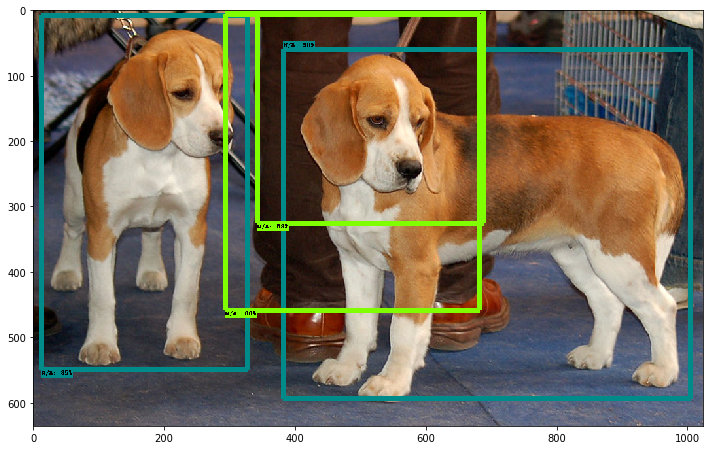

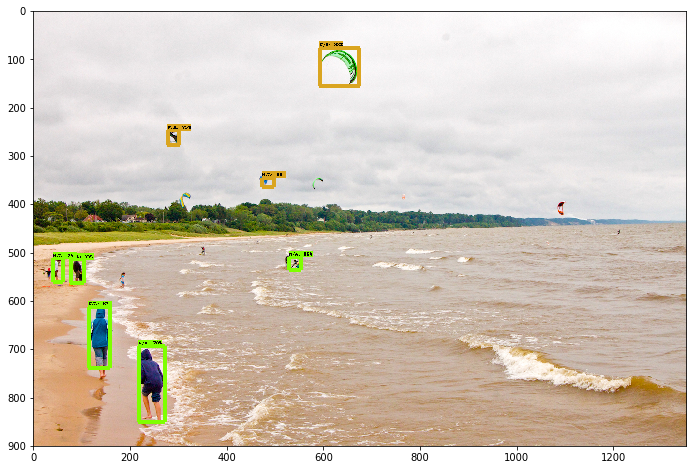

In [12]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
    
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)